<a href="https://colab.research.google.com/github/ambicapvs/ambica_info5731_spring2021/blob/main/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 3/16/2021)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [40]:
import nltk
nltk.download('stopwords')
import spacy.cli
spacy.cli.download("en")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [41]:
!pip install gensim
!pip install pyLDAvis

In [43]:
#importing packages
import re
import numpy as np
import pandas as pd
from pprint import pprint
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [44]:
#stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
#readfromcsv
dataframe = pd.read_csv("/content/scholarlytitles.csv", sep=',',engine ='python', header=0)
dataframe
#covert to list
from sklearn import datasets
data = dataframe["Title"].tolist()
print(data)
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove single quotes
data = [re.sub("\'", "", sent) for sent in data]
pprint(data[:1])
#tokenize and cleanup
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

print(data_words[:1])
#bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(trigram_mod[bigram_mod[data_words[0]]])
# functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
#calling above functions
#Stop Words
data_words_nostops = remove_stopwords(data_words)    
# Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])
#lemmatization 
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

['Data science and prediction', 'Data science in action', '[BOOK] Data Science for Business: What you need to know about data mining and data-analytic thinking', '[BOOK] What is data science?', 'Data science: a comprehensive overview', 'R for data science', 'Data science and its relationship to big data and data-driven decision making', 'Introduction to Data Science', '[BOOK] Doing data science: Straight talk from the frontline', '50 years of data science', '[BOOK] Data science', '[BOOK] Data science for undergraduates: Opportunities and options', '[BOOK] Data science from scratch: first principles with python', 'Geographic data science', 'Realizing the potential of data science', 'Big data and data science: what should we teach?', '[HTML] Data science: the impact of statistics', '[HTML] A vision for data science', '[BOOK] Data science for dummies', 'Data science in statistics curricula: Preparing students to “think with data”', 'A data science course for undergraduates: Thinking with 

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


[['datum', 'science', 'prediction']]


In [45]:
#creating dictionary and corpus
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])
#readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1)]]


[[('datum', 1), ('prediction', 1), ('science', 1)]]

In [46]:
#building model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.174*"science" + 0.070*"datum" + 0.036*"direction" + 0.036*"intelligence" '
  '+ 0.036*"practice" + 0.036*"geographic" + 0.036*"statistic" + '
  '0.036*"future" + 0.036*"prediction" + 0.036*"business"'),
 (1,
  '0.154*"datum" + 0.116*"science" + 0.071*"first" + 0.071*"course" + '
  '0.071*"principle" + 0.037*"think" + 0.037*"academic" + '
  '0.037*"undergraduate" + 0.037*"discipline" + 0.037*"scratch"'),
 (2,
  '0.163*"science" + 0.162*"datum" + 0.064*"foundation" + 0.043*"book" + '
  '0.022*"guide" + 0.022*"data" + 0.022*"paradigm" + 0.022*"new" + '
  '0.022*"case" + 0.022*"theory"'),
 (3,
  '0.137*"datum" + 0.125*"science" + 0.035*"big" + 0.035*"management" + '
  '0.035*"teach" + 0.023*"chain" + 0.023*"supply" + 0.023*"process" + '
  '0.023*"potential" + 0.023*"predictive"'),
 (4,
  '0.073*"science" + 0.037*"research" + 0.037*"problem" + 0.037*"predictive" + '
  '0.037*"supply" + 0.037*"transform" + 0.037*"big" + 0.037*"management" + '
  '0.037*"introduction" + 0.037*"insigh

In [47]:
#computing model perplexity and coherence score
#Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

#Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.7380424790815425

Coherence Score:  0.5122031750702823


In [48]:
# Visualizing topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.113157  0.139821       1        1  15.327839
7     -0.113705  0.044199       2        1  13.361098
8     -0.162538 -0.053466       3        1  10.714178
9     -0.105387  0.005761       4        1   9.711662
2     -0.121637 -0.068102       5        1   7.446274
10    -0.075412 -0.008240       6        1   5.203865
15    -0.004814  0.059648       7        1   4.536435
13     0.002177 -0.062295       8        1   4.242991
6      0.040532 -0.054863       9        1   4.195455
4      0.012296  0.118966      10        1   4.029652
0     -0.054892  0.000326      11        1   3.969523
16     0.024697 -0.085555      12        1   3.965064
1     -0.042648 -0.062075      13        1   3.922357
18     0.061187 -0.065962      14        1   3.415472
12     0.015596  0.021255      15        1   2.416899
14     0.172032  0.000250      16        1   1.422806
11     0.116419  0.017583      17        1   0.529608
5      0.116419  0.017583      18        1   0.529608
17     0.116419  0.017583      19        1   0.529608
19     0.116419  0.017583      20        1   0.529608, topic_info=             Term       Freq      Total Category  logprob  loglift
2         science  63.000000  63.000000  Default  30.0000  30.0000
0           datum  55.000000  55.000000  Default  29.0000  29.0000
4        analytic   6.000000   6.000000  Default  28.0000  28.0000
23  undergraduate   2.000000   2.000000  Default  27.0000  27.0000
54        program   2.000000   2.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
23  undergraduate   0.012559   2.160204  Topic20  -5.3083   0.0932
24          first   0.012559   1.911902  Topic20  -5.3083   0.2153
25      principle   0.012559   1.912031  Topic20  -5.3083   0.2153
28      potential   0.012559   2.268487  Topic20  -5.3083   0.0443
29        realize   0.012559   1.435446  Topic20  -5.3083   0.5020

[881 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
135       8  0.518448   academic
135      13  0.518448   academic
3         2  0.893019     action
121       2  0.703761    address
190      11  0.796598      agile
...     ...       ...        ...
33        4  0.712906     vision
134       4  0.712906  visualize
105       3  0.729888       wind
83        1  0.696647       work
146       5  0.737857  workforce

[310 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 9, 10, 3, 11, 16, 14, 7, 5, 1, 17, 2, 19, 13, 15, 12, 6, 18, 20])

In [11]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip "/content/mallet-2.0.8.zip"


--2021-03-19 15:46:45--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  15.5MB/s    in 1.0s    

2021-03-19 15:46:46 (15.5 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  /content/mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/te

In [49]:
#LDA mallet model
mallet_path = '/content/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [50]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(18,
  [('challenge', 0.21052631578947367),
   ('application', 0.15789473684210525),
   ('science', 0.10526315789473684),
   ('information', 0.10526315789473684),
   ('method', 0.05263157894736842),
   ('revolution', 0.05263157894736842),
   ('practice', 0.05263157894736842),
   ('art', 0.05263157894736842),
   ('frontline', 0.05263157894736842),
   ('student', 0.05263157894736842)]),
 (11,
  [('service', 0.2),
   ('supply', 0.13333333333333333),
   ('chain', 0.13333333333333333),
   ('future', 0.13333333333333333),
   ('comprehensive', 0.06666666666666667),
   ('high', 0.06666666666666667),
   ('extensible', 0.06666666666666667),
   ('industrial', 0.06666666666666667),
   ('pipeline', 0.06666666666666667),
   ('potential', 0.06666666666666667)]),
 (1,
  [('datum', 0.5454545454545454),
   ('book', 0.09090909090909091),
   ('tool', 0.06060606060606061),
   ('causal', 0.030303030303030304),
   ('workforce', 0.030303030303030304),
   ('discovery', 0.030303030303030304),
   ('industry', 0

In [51]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
   
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

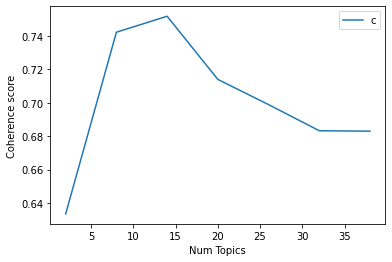

In [52]:
#graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [53]:
#coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6335
Num Topics = 8  has Coherence Value of 0.7421
Num Topics = 14  has Coherence Value of 0.7517
Num Topics = 20  has Coherence Value of 0.7139
Num Topics = 26  has Coherence Value of 0.6988
Num Topics = 32  has Coherence Value of 0.6832
Num Topics = 38  has Coherence Value of 0.683


In [54]:
# model and printing the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.238*"challenge" + 0.095*"science" + 0.048*"meet" + 0.048*"book" + '
  '0.048*"workforce" + 0.048*"management" + 0.048*"cell" + 0.048*"extensible" '
  '+ 0.048*"deep" + 0.048*"method"'),
 (1,
  '0.174*"introduction" + 0.130*"data" + 0.087*"case" + 0.087*"library" + '
  '0.087*"problem" + 0.043*"study" + 0.043*"essential" + 0.043*"optimization" '
  '+ 0.043*"benefit" + 0.043*"description"'),
 (2,
  '0.400*"science" + 0.150*"transform" + 0.100*"service" + 0.050*"nee" + '
  '0.050*"handbook" + 0.050*"discovery" + 0.050*"outlook" + 0.050*"system" + '
  '0.050*"action" + 0.050*"work"'),
 (3,
  '0.478*"science" + 0.087*"automate" + 0.043*"game" + 0.043*"talk" + '
  '0.043*"learn" + 0.043*"inference" + 0.043*"meet" + 0.043*"straight" + '
  '0.043*"action" + 0.043*"insight"'),
 (4,
  '0.138*"management" + 0.103*"big" + 0.069*"academic" + 0.069*"potential" + '
  '0.069*"teach" + 0.034*"status" + 0.034*"scalable" + 0.034*"enable" + '
  '0.034*"tree" + 0.034*"large"'),
 (5,
  '0.348*"dat

In [55]:
#finding dominant topic 
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,16.0,0.0639,"analytic, statistical, application, chance, au...",Data science and prediction
1,1,2.0,0.0577,"science, transform, service, nee, handbook, di...",Data science in action
2,2,2.0,0.0642,"science, transform, service, nee, handbook, di...",[BOOK] Data Science for Business: What you nee...
3,3,0.0,0.0500,"challenge, science, meet, book, workforce, man...",[BOOK] What is data science?
4,4,9.0,0.0648,"base, support, making, plan, relationship, tal...",Data science: a comprehensive overview
5,5,17.0,0.0566,"datum, change, view, base, prepare, guide, ise...",R for data science
6,6,9.0,0.0687,"base, support, making, plan, relationship, tal...",Data science and its relationship to big data ...
7,7,1.0,0.0652,"introduction, data, case, library, problem, st...",Introduction to Data Science
8,8,3.0,0.0807,"science, automate, game, talk, learn, inferenc...",[BOOK] Doing data science: Straight talk from ...
9,9,6.0,0.0577,"science, undergraduate, essential, principle, ...",50 years of data science


In [56]:
#top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

#Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

#Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

#Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.0798,"challenge, science, meet, book, workforce, man...",[HTML] Eleven grand challenges in single-cell ...
1,1.0,0.0804,"introduction, data, case, library, problem, st...",A case for data commons: toward data science a...
2,2.0,0.0778,"science, transform, service, nee, handbook, di...",[BOOK] Python data science handbook: Essential...
3,3.0,0.0807,"science, automate, game, talk, learn, inferenc...",[BOOK] Doing data science: Straight talk from ...
4,4.0,0.0807,"management, big, academic, potential, teach, s...",[PDF] Data science: The numbers of our lives


In [57]:
#Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

#Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

#Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

#Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

#Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

#Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,16.0,"analytic, statistical, application, chance, au...",11.0,0.11
1.0,2.0,"science, transform, service, nee, handbook, di...",6.0,0.06
2.0,2.0,"science, transform, service, nee, handbook, di...",7.0,0.07
3.0,0.0,"challenge, science, meet, book, workforce, man...",5.0,0.05
4.0,9.0,"base, support, making, plan, relationship, tal...",3.0,0.03
...,...,...,...,...
95.0,3.0,"science, automate, game, talk, learn, inferenc...",NaN,NaN
96.0,4.0,"management, big, academic, potential, teach, s...",NaN,NaN
97.0,6.0,"science, undergraduate, essential, principle, ...",NaN,NaN
98.0,8.0,"datum, science, guide, information, realize, h...",NaN,NaN


In [ ]:
#Summarization of LDA topics 
'''
1. Data science and prediction
2. Data science in action
3. Data Science for Business: What you need to know about data mining and data-analytic thinking
4. What is data science?
5. Data science: a comprehensive overview
6. R for data science
7. Data science and its relationship to big data and data-driven decision making
6. Introduction to Data Science
7. Doing data science: Straight talk from the frontline
8. 50 years of data science
9. Data science
10. Data science for undergraduates: Opportunities and options
11. Data science from scratch: first principles with python
12. Geographic data science
13. Realizing the potential of data science
14. Big data and data science: what should we teach?
15. Data science: the impact of statistics
16. A vision for data science
17. Data science for dummies
18. Data science in statistics curricula: Preparing students to ‚Äúthink with data‚Äù
19. A data science course for undergraduates: Thinking with data
20. Teaching data science
'''

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

Total Number of Documents: 101
[(0, '0.763*"data" + 0.559*"scienc" + 0.135*"big" + 0.132*"book" + 0.069*"analyt" + 0.061*"60" + 0.061*"50" + 0.058*"70" + 0.056*"0" + 0.055*"80"'), (1, '-0.514*"big" + 0.427*"book" + 0.292*"scienc" + -0.252*"analyt" + -0.212*"manag" + -0.181*"chain" + -0.181*"suppli" + -0.180*"predict" + -0.157*"data" + 0.138*"50"'), (2, '-0.583*"book" + 0.309*"scienc" + 0.248*"60" + -0.213*"analyt" + 0.179*"html" + 0.146*"health" + 0.133*"challeng" + -0.118*"data" + 0.116*"50" + -0.114*"learn"'), (3, '-0.370*"60" + -0.326*"big" + 0.245*"80" + -0.239*"challeng" + -0.230*"book" + -0.221*"health" + 0.173*"analyt" + 0.152*"program" + -0.151*"html" + 0.150*"90"'), (4, '-0.492*"90" + -0.278*"learn" + -0.196*"pdf" + -0.191*"30" + -0.187*"scalabl" + -0.187*"reproduc" + -0.187*"qiim" + -0.187*"microbiom" + -0.187*"extens" + -0.187*"interact"'), (5, '0.381*"80" + -0.316*"70" + 0.289*"program" + 0.240*"learn" + -0.227*"50" + 0.194*"machin" + -0.175*"problem" + 0.170*"big" + 0.160*

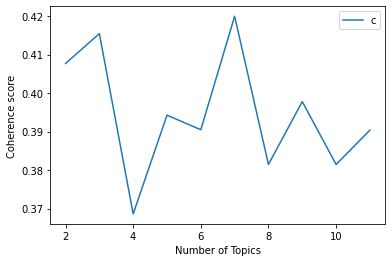

In [77]:
#import required modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

#loading data
def load_data(path,file_name):  
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

#preprocessing function
def preprocess_data(doc_set): 
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

#preparing corpus function
def prepare_corpus(doc_clean):
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

#create LSA mosel
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

#number of topics
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

#coherence plot
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


#calling above functions
number_of_topics=10
words=10
document_list,titles=load_data("/content/","scholarlytitles.csv")
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)
start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)



In [78]:
#printing topics for summarization
pprint(model.print_topics())

[(0,
  '0.763*"data" + 0.559*"scienc" + 0.135*"big" + 0.132*"book" + 0.069*"analyt" '
  '+ 0.061*"60" + 0.061*"50" + 0.058*"70" + 0.056*"0" + 0.055*"80"'),
 (1,
  '-0.514*"big" + 0.427*"book" + 0.292*"scienc" + -0.252*"analyt" + '
  '-0.212*"manag" + -0.181*"chain" + -0.181*"suppli" + -0.180*"predict" + '
  '-0.157*"data" + 0.138*"50"'),
 (2,
  '-0.583*"book" + 0.309*"scienc" + 0.248*"60" + -0.213*"analyt" + '
  '0.179*"html" + 0.146*"health" + 0.133*"challeng" + -0.118*"data" + '
  '0.116*"50" + -0.114*"learn"'),
 (3,
  '-0.370*"60" + -0.326*"big" + 0.245*"80" + -0.239*"challeng" + -0.230*"book" '
  '+ -0.221*"health" + 0.173*"analyt" + 0.152*"program" + -0.151*"html" + '
  '0.150*"90"'),
 (4,
  '-0.492*"90" + -0.278*"learn" + -0.196*"pdf" + -0.191*"30" + '
  '-0.187*"scalabl" + -0.187*"reproduc" + -0.187*"qiim" + -0.187*"microbiom" + '
  '-0.187*"extens" + -0.187*"interact"'),
 (5,
  '0.381*"80" + -0.316*"70" + 0.289*"program" + 0.240*"learn" + -0.227*"50" + '
  '0.194*"machin" + -0.

In [ ]:
#summarize LSA
'''Topic1: Data science, predictive analytics, and big data: a revolution that will transform supply chain design and management
Topic2: Data science in healthcare: benefits, challenges and opportunities
Topic3: Data science programs in US higher education: An exploratory content analysis of program description, curriculum structure, and course focus
Topic4: Big data science: opportunities and challenges to address minority health and health disparities in the 21st century
Topic5: Reproducible, interactive, scalable and extensible microbiome data science using QIIME 2
Topic6: Introducing data science: big data, machine learning, and more, using Python tools
Topic7: Curriculum guidelines for undergraduate programs in data science
Topic8: QIIME 2: Reproducible, interactive, scalable, and extensible microbiome data science
Topic9: Inverse statistical problems: from the inverse Ising problem to data science
Topic10: Automating biomedical data science through tree-based pipeline optimization
'''


## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
The optimal coherent score of Latent Dirichlet allocation obtained for above example is 0.51 which 
is greater than the optimal coherent score of latent semantic analysis which is 0.45.Latent semantic 
analysis has less accuracy when compared to Latent dirichlet allocation. As LDA has better accuracy, 
it is easy use LDA for generalizing the new topics or new documents.LSA has less efficiency in 
representation.LSA is less interpretable compared to LDA because of the dimensionality reduction. 